In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

In [90]:
data_train = pd.read_csv('../finance_dataset/train.csv')

In [91]:
data_test = pd.read_csv('../finance_dataset/testA.csv')

### 填充缺失值

In [92]:
# employmentLength为类别型变量，使用前填充
data_train.fillna(method='ffill',inplace=True)
data_test.fillna(method='ffill',inplace=True)

### 数据特征

连续数据和类别数据，类别数据中要区分是onehot编码还是标签编码

一个特征有50个属性值，是当做类别还是连续数据处理

In [93]:
object_data=data_train.select_dtypes(include='object')
object_data.columns

Index(['grade', 'subGrade', 'employmentLength', 'issueDate',
       'earliesCreditLine'],
      dtype='object')

In [94]:
numeraic_data=data_train.select_dtypes(include=['int64','float64'])

In [95]:
numeraic_data=data_train.select_dtypes(include=['int64','float64'])
# num_data
def get_num_obj_data(data,feas):
    num_obj_data_columns = []
    for fea in feas:
        num = data[fea].nunique()

        if num<20:
            num_obj_data_columns.append(fea)
    return num_obj_data_columns
num_cat_col = get_num_obj_data(data_train,numeraic_data.columns)

In [96]:
num_cat_col

['term',
 'homeOwnership',
 'verificationStatus',
 'isDefault',
 'purpose',
 'pubRecBankruptcies',
 'initialListStatus',
 'applicationType',
 'policyCode',
 'n11',
 'n12']

In [97]:
# 其中，policy只有一个值，所以去掉这个特征
for name in num_cat_col:
    print(data_train[name].nunique())


2
6
3
2
14
11
2
2
1
5
5


In [98]:
num_nocat_col = [col for col in numeraic_data.columns if col not in num_cat_col]
num_nocat_col

['id',
 'loanAmnt',
 'interestRate',
 'installment',
 'employmentTitle',
 'annualIncome',
 'postCode',
 'regionCode',
 'dti',
 'delinquency_2years',
 'ficoRangeLow',
 'ficoRangeHigh',
 'openAcc',
 'pubRec',
 'revolBal',
 'revolUtil',
 'totalAcc',
 'title',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n13',
 'n14']

In [99]:
num_cat_col.remove('policyCode')

num_nocat_col.remove('id')

In [100]:
all_col=num_cat_col+num_nocat_col
len(all_col)

40

In [ ]:
5列object+41列numeric[其中一个为id列，一个只有一个值的列]+1标签列=47列

去掉的列：
id是编号

以上共有3类特征，字符类型的类别特征，数值类型的类别特征，数值型的连续数据
以下对类别特征和连续数据进行处理和分析

In [105]:
other_feature = []

### 时间格式处理

对object类型数据处理 ['grade', 'subGrade', 'employmentLength', 'issueDate','earliesCreditLine']

In [101]:
# 连续数据
# issueDateDT得到的是天数
for data in [data_train,data_test]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01','%Y-%m-%d')
    data['issueDateDT'] = data['issueDate'].apply(lambda x:x-startdate).dt.days

In [106]:
other_feature.append('issuDate')

In [191]:
# 2007-06-01是最小日期
data.loc[data_train['issueDateDT']<=0,'issueDate']

Series([], Name: issueDate, dtype: datetime64[ns])

In [107]:
# 类别数据-onehot
# earliesCreditLine为类别型数据，但是，类别太多，取出earliesCreditLine年份
for data in [data_train,data_test]:
    data['earliesCreditLine_year'] = data['earliesCreditLine'].apply(lambda x:int(x[-4:]))
    

In [8]:
# sort_index按照索引排序
data_test['employmentLength'].value_counts().sort_index()

1 year       14017
10+ years    69874
2 years      19347
3 years      17012
4 years      12566
5 years      13324
6 years       9898
7 years       9304
8 years       9595
9 years       8073
< 1 year     16990
Name: employmentLength, dtype: int64

### 对象类型特征转换到数值

去掉只有一个值的特征policyCode
isDafault是标签变量
issueDate已经被转化为了天数
earliesCreditLine为类别型数据，转化为天数
grade有优先级，需要进行标签编码，而不是onehot编
employmentLength 将年份提取出来

In [32]:
['grade', 'subGrade', 'employmentLength', 'issueDate','earliesCreditLine']+['term',
 'homeOwnership',
 'verificationStatus',
 'isDefault',
 'purpose',
 'pubRecBankruptcies',
 'initialListStatus',
 'applicationType',
 'policyCode',
 'n11',
 'n12']

#### 对字符类型的类别特征处理

In [109]:
# grade，类别标签-标签编码
# 因为grade有优先级，亦等级，所以要标签编码
dict_grade = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7}
for data in [data_train,data_test]:
    data['grade_label2code'] = data['grade'].map(dict_grade)

In [110]:
# 类别标签-onehot
# 对employmentLength_to_int进行处理，然后只用年份来表示数据
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return int(s.split()[0])
for data in [data_train,data_test]:
    data['employmentLength'].replace('10+ years','10 years',inplace=True)
    data['employmentLength'].replace('< 1 year','0 years',inplace=True)
    data['employmentLength_label2code']=data['employmentLength'].apply(employmentLength_to_int)

In [111]:
# 类别标签-标签编码
# subgrade
dict_sgrade=data_train['subGrade'].unique()
dict_sgrade=sorted(dict_sgrade)
dict_sgrade = {dict_sgrade[i]:i for i in range(len(dict_sgrade))}
for data in [data_train,data_test]:
    data['subGrade_label2code'] = data['subGrade'].map(dict_sgrade)

In [112]:
data_test.shape,data_train.shape

((200000, 51), (800000, 52))

年份是one-hot编码还是label_encode比较好

## 异常值处理

连续变量做 3segma

In [25]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [26]:
# data_train = data_train_cated.copy()
for fea in num_nocat_col:
    data_test = find_outliers_by_3segama(data_test,fea)
    data_train = find_outliers_by_3segama(data_train,fea)
#     print(data_train[fea+'_outliers'].value_counts())
#     print(data_train.groupby(fea+'_outliers')['isDefault'].sum())
#     print('*'*10)

### 标签分布查看
是否不平衡

In [54]:
data_train['isDefault'].value_counts()

0    640390
1    159610
Name: isDefault, dtype: int64

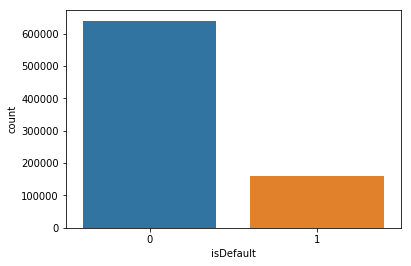

In [53]:
sns.countplot(data=data_train,x='isDefault')

这个也看不出来史啥意思

### 分箱

#### 固定宽度分箱

In [113]:
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000,只取整，不要余数
data_train['loanAmnt_bin1'] = np.floor_divide(data_train['loanAmnt'], 1000)
data_test['loanAmnt_bin1'] = np.floor_divide(data_test['loanAmnt'], 1000)

In [114]:
data_test.shape,data_train.shape

((200000, 52), (800000, 53))

In [76]:
## 通过对数函数映射到指数宽度分箱
data['loanAmnt_bin2'] = np.floor(np.log10(data_train['loanAmnt']))

In [77]:
data['loanAmnt_bin2'].value_counts()

4.0    132073
3.0     67926
2.0         1
Name: loanAmnt_bin2, dtype: int64

<AxesSubplot:xlabel='loanAmnt', ylabel='Density'>

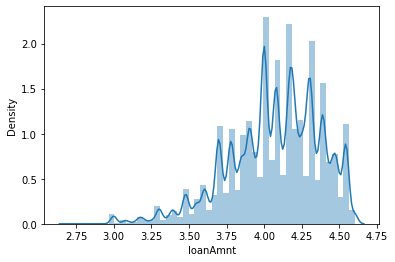

In [78]:
sns.distplot(np.log10(data_train['loanAmnt']))

<AxesSubplot:xlabel='loanAmnt', ylabel='Density'>

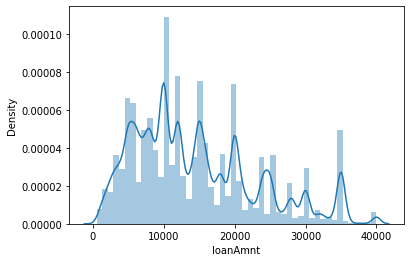

In [79]:
sns.distplot(data_train['loanAmnt'])

#### 分位数分箱-不太懂

In [116]:
# 将数据按排序后，分成10份，每份中的数据个数相同
data_train['loanAmnt_bin3'] = pd.qcut(data_train['loanAmnt'],10,labels=False)
data_test['loanAmnt_bin3'] = pd.qcut(data_test['loanAmnt'],10,labels=False)

qcut用法

In [94]:
a=np.random.randint(100,size=10)
print(a)
pd.qcut(a, 5, labels=False)

[68 78 70 79 72 93 64 82 66 35]


array([1, 3, 2, 3, 2, 4, 0, 4, 1, 0], dtype=int64)

In [144]:
data_train['employmentTitle'].nunique()

248683

#### 特征和特征之间衍生

In [118]:
for col in ['grade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.set_index('grade',inplace=True)
    temp_dict = temp_dict[col + '_target_mean'].to_dict()
    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test[col + '_target_mean'] = data_test[col].map(temp_dict)

#### 其它特征衍生的尝试

In [120]:
# 其他衍生变量 mean 和 std,按照grade分组，计算每个组内，n0,n1,....,n14的均值和标准差
fea = np.array(num_nocat_col)
for df in [data_train, data_test]:
    for item in fea:
        df['grade_to_mean_' + item] = df[item] / df.groupby('grade')[item].transform('mean')
        df['grade_to_std_' + item] = df[item] / df.groupby('grade')[item].transform('std')

In [121]:
data_test.shape,data_train.shape

((200000, 114), (800000, 115))

### 特征编码
哪些数据可以onehot编码，哪些数据适合标签编码
- one-hot编码
- label-encode编码

In [265]:
num_cat_col.remove('isDefault')
cate_feature = num_cat_col

data_train = pd.get_dummies(data_train,columns=cate_feature)
data_test = pd.get_dummies(data_test,columns=cate_feature)

In [84]:
data_train[['employmentTitle', 'postCode', 'title']][:5]

,employmentTitle,postCode,title
0,192025,43,1
1,104733,64,6326
2,189509,265,0
3,249631,55,26200
4,256267,226,910


In [83]:
data_train[['employmentTitle', 'postCode', 'title']].nunique()

employmentTitle    248683
postCode              932
title               39644
dtype: int64

In [33]:
for col in tqdm(['employmentTitle', 'postCode', 'title']):
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test[col] = le.transform(list(data_test[col].astype(str).values))
print('Label Encoding 完成')

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.14s/it]

Label Encoding 完成


### 逻辑回归等模型要单独增加的特征工程
- 对特征做归一化，去除相关性高的特征
- 归一化的目的是让训练过程更好更快的收敛，避免特征大吃小的问题
- 去除相关性是增加模型的可解释性，加快预测过程

In [85]:
# 举例归一化过程
#伪代码
for fea in [要归一化的特征列表]：
    data[fea] = ((data[fea] - np.min(data[fea])) / (np.max(data[fea]) - np.min(data[fea])))

SyntaxError: invalid character in identifier (<ipython-input-85-fa43f959a4d9>, line 3)

### 特征选择

特征选择技术可以精简掉无用的特征，以降低最终模型的复杂性，它的最终目的是得到一个简约模型，在不降低预测准确率或对预测准确率影响不大的情况下提高计算速度。特征选择不是为了减少训练时间（实际上，一些技术会增加总体训练时间），而是为了减少模型评分时间。
1. Filter
- 方差选择法
- 相关系数法（pearson相关系数）
- 卡方检验
- 互信息法
2. Wrapper(RFE)
- 递归特征消除法
3. Embedded
- 基于惩罚项的特征选择法
- 基于树模型的特征选择

#### Filter-方差选择法
这些选择是基于连续变量还是标签变量

In [275]:
from sklearn.feature_selection import VarianceThreshold
#其中参数threshold为方差的阈值

selector = VarianceThreshold(threshold=3)
selector.fit_transform(data_train[fea])

array([[3.5000e+04, 1.9520e+01, 9.1797e+02, ..., 2.0000e+00, 7.0000e+00,
        2.0000e+00],
       [1.8000e+04, 1.8490e+01, 4.6190e+02, ..., 2.0000e+00, 1.3000e+01,
        2.0000e+00],
       [1.2000e+04, 1.6990e+01, 2.9817e+02, ..., 3.0000e+00, 1.1000e+01,
        4.0000e+00],
       ...,
       [6.0000e+03, 1.3330e+01, 2.0312e+02, ..., 4.0000e+00, 5.0000e+00,
        4.0000e+00],
       [1.9200e+04, 6.9200e+00, 5.9214e+02, ..., 8.0000e+00, 1.6000e+01,
        5.0000e+00],
       [9.0000e+03, 1.1060e+01, 2.9491e+02, ..., 3.0000e+00, 7.0000e+00,
        2.0000e+00]])

In [276]:
# 方差大于阈值的特征
fea=fea[selector.variances_>selector.threshold]
len(fea)

26

In [216]:
len(fea)

30

方差选择法-练习

In [96]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 2, 0], [9, 1, 4], [0, 1, 6]]
print(X)
selector = VarianceThreshold(threshold=2)
selector.fit_transform(X)


[[0, 2, 0], [9, 1, 4], [0, 1, 6]]


array([[0, 0],
       [9, 4],
       [0, 6]])

In [98]:
print(X)

[[0, 2, 0], [9, 1, 4], [0, 1, 6]]


fit表示只从数据中学习方差，但是并不会应用
但是,fit_transform不止会学习方差，还会应用在数据上，完成了两个操作

In [97]:
# 通过variances_属性查看样本各个特征的方差
print(selector.variances_)

[18.          0.22222222  6.22222222]


参考链接：https://blog.csdn.net/kancy110/article/details/72835050

### 卡方检验

经典的卡方检验是用于检验自变量对因变量的相关性，假设自变量有N种取值，因变量有M种取值，考虑自变量等于i且因变量等于j的样本频数的观察值与期望的差距。其统计量如下

注意：卡方只能用在正定矩阵上，否则会报错Input X must be non-negative)

In [123]:
# num_cat_col.extend(['loanAmnt_bin3','loanAmnt_bin1','earliesCreditLine_year','employmentLength_label2code'])
# fea = np.array(num_cat_col)
y_train = data_train.isDefault
num_cat_col.remove('isDefault')

In [126]:
num_cat_col

['term',
 'homeOwnership',
 'verificationStatus',
 'purpose',
 'pubRecBankruptcies',
 'initialListStatus',
 'applicationType',
 'n11',
 'n12']

In [127]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#参数k为选择的特征个数,评分最高的5个特征

selector_kf = SelectKBest(chi2, k=6)
selector_kf.fit_transform(data_train[num_cat_col],data_train['isDefault'])

array([[5., 2., 2., 1., 0., 0.],
       [5., 0., 2., 0., 0., 0.],
       [5., 0., 2., 0., 0., 0.],
       ...,
       [3., 1., 2., 0., 0., 0.],
       [3., 0., 2., 4., 0., 0.],
       [3., 0., 0., 4., 0., 0.]])

In [148]:
fea = np.array(num_cat_col)
s = selector_kf.scores_
kf_col = fea[np.argpartition(s,-6)[-6:]]
kf_col

array(['applicationType', 'pubRecBankruptcies', 'homeOwnership',
       'purpose', 'verificationStatus', 'term'], dtype='<U18')

In [155]:
other_feature=[]

In [156]:
# 特征得分，得分越高表示，表示该特征越好
bool_kf = np.isin(fea,kf_col,invert=True).tolist()
other_feature.extend(fea[bool_kf])
other_feature

['initialListStatus', 'n11', 'n12']

#### argpartition的使用

参考链接：
- https://blog.csdn.net/snowdroptulip/article/details/78867053
- https://www.pythonheidong.com/blog/article/327681/

In [196]:
# p值越小，置信度越高，特征并不是按照这个排序的
p=selector_kf.pvalues_
fea[np.argpartition(p,-5)[-5:]]

array(['n0', 'n8', 'n4', 'n13', 'n6'], dtype='<U3')

In [132]:
z = np.array([1,4,3,0, 2, 5])
print(z)
print(z[np.argpartition(z,-2)][-2:])


[1 4 3 0 2 5]
[4 5]


In [162]:
a = np.array([9, 5.5, 2, 3, 7, 11, 0, 4.9, 6, 0])

In [172]:
# kth = [1,2]，找到对第1,2大的数（两个数之间会进行排序），比它小的数放到它前边，并进行排序；比它大的数放到它后边，但并不会进行排序，保持原顺序。
ind = np.argpartition(a, [3,6])
a[ind]

array([ 0. ,  0. ,  2. ,  3. ,  4.9,  5.5,  6. ,  7. , 11. ,  9. ])

#### embedded

计算协方差，可是，协方差有什么用

In [218]:
x_train = data_train[fea].drop(['isDefault'], axis=1)
# 计算协方差
data_corr = x_train.corrwith(data_train[fea].isDefault) # 计算相关性
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values

#### 用热图查看

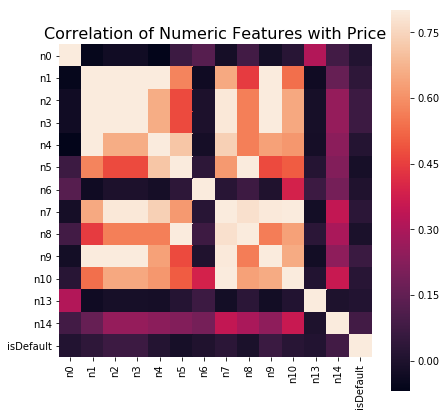

In [221]:
# 当然也可以直接看图
data_numeric = data_train[fea[:-1]]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

### 当存在3segma时需要将这个outliers列进行删除

In [277]:
def get_feature(df):
    all_col = df.columns.to_list()
    return [col for col in all_col if '_outliers' not in col]
train_feature_col = get_feature(data_train)
test_feature_col = get_feature(data_test)

In [279]:
print(len(train_feature_col))
print(len(test_feature_col))

233
230


In [281]:
data_train = data_train[train_feature_col]
data_test = data_test[test_feature_col]

### 删除不需要的特征

In [159]:
other_feature.extend(['issueDate','id','policyCode','employmentLength','grade','subGrade','earliesCreditLine'])
other_feature

['initialListStatus',
 'n11',
 'n12',
 'issueDate',
 'id',
 'policyCode',
 'employmentLength',
 'grade',
 'subGrade',
 'earliesCreditLine']

In [161]:
# 删除不需要的数据
for data in [data_train, data_test]:
    data.drop(other_feature, axis=1,inplace=True)

### 保存特征

In [ ]:
data_train.to_csv('../finance_dataset/features/feature_001.csv',encoding='utf-8')

### 调参

#### 切分数据

In [181]:
Y_train = data_train.isDefault
X_train = data_train.drop('isDefault',axis=1)
X_test = data_test

In [172]:
from sklearn.model_selection import train_test_split

In [190]:
# 按照y标签分层抽样
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train,shuffle=True,test_size=0.1,stratify=Y_train)

In [175]:
X_train.shape,X_test.shape

((720000, 104), (80000, 104))

用贝叶斯得到最优参数

In [165]:
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

先使用一个大的学习率0.1确定树的个数，也就是迭代次数

In [ ]:
"""调整一个较小的学习率，并通过cv函数确定当前最优的迭代次数"""
base_params_lgb = {
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'learning_rate': 0.01,
                    'num_leaves': 14,
                    'max_depth': 19,
                    'min_data_in_leaf': 37,
                    'min_child_weight':1.6,
                    'bagging_fraction': 0.98,
                    'feature_fraction': 0.69,
                    'bagging_freq': 96,
                    'reg_lambda': 9,
                    'reg_alpha': 7,
                    'min_split_gain': 0.4,
                    'nthread': 8,
                    'seed': 2020,
                    'silent': True,
                    'verbose': -1,
}

cv_result_lgb = lgb.cv(
    train_set=train_matrix,
    early_stopping_rounds=1000, 
    num_boost_round=20000,
    nfold=5,
    stratified=True,
    shuffle=True,
    params=base_params_lgb,
    metrics='auc',
    seed=0
)

print('迭代次数/树的个数{}'.format(len(cv_result_lgb['auc-mean'])))
print('最终模型的AUC为{}'.format(max(cv_result_lgb['auc-mean'])))

确定树的个数后，再确定其它的参数

In [186]:
"""定义优化函数"""
def rf_cv_lgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf, 
              min_child_weight, min_split_gain, reg_lambda, reg_alpha):
    # 建立模型
    model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='auc',
                                   learning_rate=0.1, n_estimators=5000,
                                   num_leaves=int(num_leaves), max_depth=int(max_depth), 
                                   bagging_fraction=round(bagging_fraction, 2), feature_fraction=round(feature_fraction, 2),
                                   bagging_freq=int(bagging_freq), min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight, min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    
    val = cross_val_score(model_lgb, x_train, y_train, cv=5, scoring='roc_auc').mean()
    
    return val

In [187]:
"""定义优化参数"""
bayes_lgb = BayesianOptimization(
    rf_cv_lgb, 
    {
        'num_leaves':(10, 200),
        'max_depth':(3, 20),
        'bagging_fraction':(0.5, 1.0),
        'feature_fraction':(0.5, 1.0),
        'bagging_freq':(0, 100),
        'min_data_in_leaf':(10,100),
        'min_child_weight':(0, 10),
        'min_split_gain':(0.0, 1.0),
        'reg_alpha':(0.0, 10),
        'reg_lambda':(0.0, 10),
    }
)

In [188]:
"""开始优化"""
bayes_lgb.maximize(n_iter=10)

|   iter    |  target   | baggin... | baggin... | featur... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] Unknown parameter: bjective
[LightGBM] [Warning] feature_fraction is set=0.67, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.67
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=89, subsample_freq=0 will be ignored. Current value: bagging_freq=89
[LightGBM] [Warning] Unknown parameter: bjective
[LightGBM] [Warning] feature_fraction is set=0.67, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.67
[LightGBM

KeyboardInterrupt: 

确定其它参数后，再使用一个较小的学习率0.01或者0.05，确定树的个数

In [ ]:
"""调整一个较小的学习率，并通过cv函数确定当前最优的迭代次数"""
base_params_lgb = {
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'learning_rate': 0.01,
                    'num_leaves': 14,
                    'max_depth': 19,
                    'min_data_in_leaf': 37,
                    'min_child_weight':1.6,
                    'bagging_fraction': 0.98,
                    'feature_fraction': 0.69,
                    'bagging_freq': 96,
                    'reg_lambda': 9,
                    'reg_alpha': 7,
                    'min_split_gain': 0.4,
                    'nthread': 8,
                    'seed': 2020,
                    'silent': True,
                    'verbose': -1,
}

cv_result_lgb = lgb.cv(
    train_set=train_matrix,
    early_stopping_rounds=1000, 
    num_boost_round=20000,
    nfold=5,
    stratified=True,
    shuffle=True,
    params=base_params_lgb,
    metrics='auc',
    seed=0
)

print('迭代次数/树的个数{}'.format(len(cv_result_lgb['auc-mean'])))
print('最终模型的AUC为{}'.format(max(cv_result_lgb['auc-mean'])))

确定以上的所有参数后，再确定模型，在验证集上进行五折交叉验证，看下效果怎么样

这个交叉验证感觉挺多余，都已经确定最优参数了，为啥还要进行5折交叉验证

In [ ]:
"""使用lightgbm 5折交叉验证进行建模预测"""
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train[train_index], X_train.iloc[valid_index], y_train[valid_index]
    
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'learning_rate': 0.01,
                'num_leaves': 14,
                'max_depth': 19,
                'min_data_in_leaf': 37,
                'min_child_weight':1.6,
                'bagging_fraction': 0.98,
                'feature_fraction': 0.69,
                'bagging_freq': 96,
                'reg_lambda': 9,
                'reg_alpha': 7,
                'min_split_gain': 0.4,
                'nthread': 8,
                'seed': 2020,
                'silent': True,
    }
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=14269, valid_sets=valid_matrix, verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

使用模型对测试数据进行预测

num_boost_round=n，就停止了，可以在下面验证中设置轮数为n

In [191]:
train_matrix = lgb.Dataset(x_train, label=y_train)
valid_matrix = lgb.Dataset(x_val, label=y_val)
base_params_lgb = {
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'learning_rate': 0.01,
                    'num_leaves': 14,
                    'max_depth': 19,
                    'min_data_in_leaf': 37,
                    'min_child_weight':1.6,
                    'bagging_fraction': 0.98,
                    'feature_fraction': 0.69,
                    'bagging_freq': 96,
                    'reg_lambda': 9,
                    'reg_alpha': 7,
                    'min_split_gain': 0.4,
                    'nthread': 8,
                    'seed': 2020,
                    'silent': True,
}

"""使用训练集数据进行模型训练"""
# 这里为啥要放验证集
final_model_lgb = lgb.train(base_params_lgb, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=13000, verbose_eval=1000, early_stopping_rounds=200)

"""预测并计算roc的相关指标"""
val_pre_lgb = final_model_lgb.predict(X_val)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 143649, number of negative: 576351
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.442377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16449
[LightGBM] [Info] Number of data points in the train set: 720000, number of used features: 104
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199513 -> initscore=-1.389344
[LightGBM] [Info] Start training from score -1.389344
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.725708
[2000]	valid_0's auc: 0.729438
[3000]	valid_0's auc: 0.730811
[4000]	valid_0's auc: 0.7315
[5000]	valid_0's auc: 0.731985
[6000]	valid_0's auc: 0.732453
[7000]	valid_0's auc: 0.732766
[8000]	valid_0's auc: 0.733089
[9000]	valid_0's auc: 0.733356
Early stopping, best iteration is:
[9327]	valid_0's auc: 0.733411

NameError: name 'X_val' is not defined

绘制roc_auc图形

In [ ]:
def plot_roc_auc(fpr,tpr,roc_auc):
    print('调参后lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
    """画出roc曲线图"""
    plt.figure(figsize=(8, 8))
    plt.title('Validation ROC')
    plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.legend(loc='best')
    plt.title('ROC')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # 画出对角线
    plt.plot([0,1],[0,1],'r--')
    plt.show()
plot_roc_auc(fpr,tpr,roc_auc)

### 构建模型

In [294]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration,predict_disable_shape_check=True)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
#         这个测试集不知道为什么要除以kf.n_splits
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [295]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")

In [296]:
data_train.shape,data_test.shape

((800000, 226), (200000, 223))

In [284]:
y_train = data_train.isDefault

In [285]:
x_train = data_train.drop(['isDefault'], axis=1)
x_train.shape

(800000, 225)

In [286]:
x_test = data_test

In [288]:
x_test.shape

(200000, 223)

In [297]:
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[LightGBM] [Warning] num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.748425	valid_1's auc: 0.735345
[400]	training's auc: 0.762305	valid_1's auc: 0.735958
[600]	training's auc: 0.774127	valid_1's auc: 0.735703
Early stopping, best iteration is:
[429]	training's auc: 0.764143	valid_1's auc: 0.736023
[0.736022819251776]
************************************ 2 ************************************
[LightGBM] [Warning] num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.749224	valid_1's auc: 0.731302
[400]	training's auc: 0.762781	valid_1's auc: 0.732235
[600]

In [300]:
lgb_test

array([0.02742824, 0.06436508, 0.09324969, ..., 0.05495921, 0.07631225,
       0.01156416])

In [301]:
lgb_train

array([0.27327223, 0.26690831, 0.4664745 , ..., 0.24542784, 0.05830645,
       0.04559115])

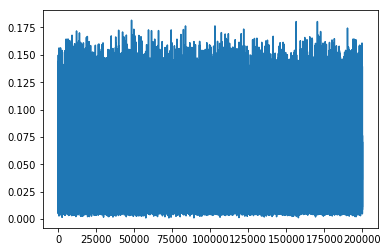

In [302]:
plt.plot(lgb_test)

### 保存文件

将概率值转化为0,1

In [331]:
# 0.09的分数比0.076的低，所以，阈值可能需要设置的更低，但是，如何设置这个阈值呢
threshold = 0.076
result = pd.Series([1 if pred > threshold else 0 for pred in lgb_test])


In [323]:
b=result.value_counts()
b[1]/b[0]

0.2157906894749

In [321]:
a=y_train.value_counts()
a[1]/a[0]

0.2492387451396805

In [325]:
test = pd.read_csv('../finance_dataset/sample_submit.csv')

In [332]:
test['isDefault'] = result

In [333]:
test

,id,isDefault
0,800000,0
1,800001,0
2,800002,1
3,800003,0
4,800004,1
...,...,...
199995,999995,0
199996,999996,0
199997,999997,0
199998,999998,0


In [334]:
test.to_csv('../finance_dataset/result/submit_solo_02.csv',encoding='utf-8')

如何看阈值设置多少合适